# Titanic Survival Model

## Preliminary Analysis

This Jupyter Notebook is assumed to be in the same directory as the supplied Kaggle datasets, stored in "train.csv" and "test.csv" respectively. 

Preliminary analysis of the datasets can be found below, with a view to:
   1. Familiarise oneself with the nuances of the datasets, including:
       * Variables
       * Missing data
       * Volume of data
        
   2. Perform single-factor analysis prior to feeding the data into the model, with a view to evaluating the suitability of each variable for inclusion in the final model(s)
   
   3. Put in place a data-cleaning procedure for use in the model scripts

### Dataset Familiarisation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [3]:
for column, col_type in zip(train_data.columns, train_data.dtypes):
    print("Var:", column, 
          "\t\tNull Count:", train_data[column].isnull().sum(), 
          "\t\tType:", col_type)

Var: PassengerId 		Null Count: 0 		Type: int64
Var: Survived 		Null Count: 0 		Type: int64
Var: Pclass 		Null Count: 0 		Type: int64
Var: Name 		Null Count: 0 		Type: object
Var: Sex 		Null Count: 0 		Type: object
Var: Age 		Null Count: 177 		Type: float64
Var: SibSp 		Null Count: 0 		Type: int64
Var: Parch 		Null Count: 0 		Type: int64
Var: Ticket 		Null Count: 0 		Type: object
Var: Fare 		Null Count: 0 		Type: float64
Var: Cabin 		Null Count: 687 		Type: object
Var: Embarked 		Null Count: 2 		Type: object


In [4]:
null_perc = [train_data[column].isnull().sum()/train_data['PassengerId'].count() for column in train_data.columns]

dq = pd.DataFrame(index=np.arange(0,len(train_data.columns)), columns=["Variable","Missing"],dtype=int)
index = 0
for col, nulls in zip(train_data.columns, null_perc):
    dq.loc[index] = [col, nulls]
    index += 1
dq

,Variable,Missing
0,PassengerId,0.000000
1,Survived,0.000000
2,Pclass,0.000000
3,Name,0.000000
4,Sex,0.000000
5,Age,0.198653
6,SibSp,0.000000
7,Parch,0.000000
8,Ticket,0.000000
9,Fare,0.000000


In [5]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
test_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


## Feature Engineering
We can derive new variables to increase their suitability for modelling purposes. We can then compare these engineered variables with their original counterparts, where applicable.

For example, the engineered variable "is_female" will replace the original variable "Sex" as this is achieving two things simultaneously:
1. It codifies a string variable into a numeric, but still categorical, variable. String variables are not unsuitable for most machine learning algorithms.
2. We expect that the female classification, or where "is_female" = 1, will have a higher probability of survival then the male classification. Hence, codifying in a manner that reinforces this intuition is preferable.

However, we will also normalise and log-normalise the Age and Fare variables and compare these with the originals to select which variation is more predictive. The engineered variables will only replace the originals if they perform better.

In [8]:
# Functions to generate new fields
def is_female(string):
    if string == "female":
        return 1
    else:
        return 0
    
def cabin_missing(cabin):
    if not type(cabin) == str:
        if np.isnan(cabin):
            return 1
    
    else:
        if cabin == "":
            return 1
        else:
            return 0

def age_missing(num):
    if np.isnan(num):
        return 1
    else:
        return 0
    
def embarked_cde(letter):
    if letter == "S":
        return 1
    
    elif letter == "C":
        return 2
    
    elif letter == "Q":
        return 3
    
    else:
        return 0
    
def normalise(x, mu, sigma):
    # Given the mean (mu) and standard deviation (sigma) of a series, with the series S being described as:
    # S = {x_i}, i = {0, 1, ..., N-1} for a series of length N,
    # the normalised series S_norm = {x_i_norm} where
    # x_i_norm = (x_i - mu)/sigma
    return (x - mu)/sigma

In [9]:
train_data_mod = train_data

# Codifying variables
train_data_mod["is_female"] = train_data_mod["Sex"].apply(is_female)
train_data_mod["cabin_missing"] = train_data_mod["Cabin"].apply(cabin_missing)
train_data_mod["age_missing"] = train_data_mod["Age"].apply(age_missing)
train_data_mod["embarked_cde"] = train_data_mod["Embarked"].apply(embarked_cde)

# Age transforms
train_age_mean = train_data_mod["Age"].mean()
train_age_std = train_data_mod["Age"].std()

train_data_mod["Age"] = train_data_mod["Age"].fillna(train_age_mean) # Filling values (using mean)
train_data_mod["age_log"] = np.log(train_data_mod["Age"]) # Log of age. We can take log of the field as it is as min > 0

train_age_log_mean = train_data_mod["age_log"].mean()
train_age_log_std = train_data_mod["age_log"].std()

train_data_mod["age_norm"] = train_data_mod.apply(lambda df: normalise(df["Age"], train_age_mean, train_age_std), axis=1)
train_data_mod["age_lognorm"] = train_data_mod.apply(lambda df: normalise(df["age_log"], train_age_log_mean, train_age_log_std), axis=1)

# Fare transforms
train_fare_mean = train_data_mod["Fare"].mean()
train_fare_std = train_data_mod["Fare"].std()

train_data_mod["fare_log"] = np.log(train_data_mod["Fare"] + 1) # Min fare = 0, which is undefined in log space. Log(x + 1) ~ log(x)

train_fare_log_mean = train_data_mod["fare_log"].mean()
train_fare_log_std = train_data_mod["fare_log"].std()

train_data_mod["fare_norm"] = train_data_mod.apply(lambda df: normalise(df["Fare"], train_fare_mean, train_fare_std), axis=1)
train_data_mod["fare_lognorm"] = train_data_mod.apply(lambda df: normalise(df["fare_log"], train_fare_log_mean, train_fare_log_std), axis=1)

train_data_mod.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,is_female,cabin_missing,age_missing,embarked_cde,age_log,age_norm,age_lognorm,fare_log,fare_norm,fare_lognorm
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,8.910000e+02,8.910000e+02,891.000000,8.910000e+02,8.910000e+02
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.352413,0.771044,0.198653,1.359147,3.234606,1.874046e-16,-7.416439e-16,2.962246,-1.196200e-17,-1.874046e-16
std,257.353842,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429,0.477990,0.420397,0.399210,0.638707,0.706606,8.950551e-01,1.000000e+00,0.969048,1.000000e+00,1.000000e+00
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.867501,-2.015566e+00,-5.805368e+00,0.000000,-6.480577e-01,-3.056861e+00
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000,1.000000,0.000000,1.000000,3.091042,-5.300051e-01,-2.031735e-01,2.187218,-4.888737e-01,-7.997826e-01
50%,446.000000,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200,0.000000,1.000000,0.000000,1.000000,3.391117,0.000000e+00,2.214974e-01,2.737881,-3.571902e-01,-2.315312e-01
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,1.000000,1.000000,0.000000,2.000000,3.555348,3.649113e-01,4.539194e-01,3.465736,-2.423274e-02,5.195718e-01
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,3.000000,4.382027,3.462699e+00,1.623848e+00,6.240917,9.661740e+00,3.383393e+00


In [10]:
train_data_mod.drop(["Sex", "Cabin", "Embarked", "PassengerId", "Name", "Ticket"], axis=1, inplace=True)

### SFA and factor shortlisting

We can now estimate the predictive power of each factor by calculating their WoE and IV values.

In [11]:
def iv_woe(data, target, bins=10, factor_exclusions=[]):
    
    #Empty Dataframe
    ivDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    all_exclusions = factor_exclusions + [target]
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([factor for factor in all_exclusions])]:
        
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
            
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        ivDF=pd.concat([ivDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)
    
    return ivDF, woeDF

In [12]:
ivDF, woeDF = iv_woe(train_data_mod, 'Survived', factor_exclusions=[])

In [13]:
print(ivDF.sort_values(by=['IV'], ascending=False).to_string(index=False))

      Variable        IV
     is_female  1.341681
          Fare  0.625860
      fare_log  0.625860
     fare_norm  0.625860
  fare_lognorm  0.625860
        Pclass  0.500950
 cabin_missing  0.421963
         SibSp  0.180868
  embarked_cde  0.131556
         Parch  0.124605
           Age  0.105002
       age_log  0.105002
      age_norm  0.105002
   age_lognorm  0.105002
   age_missing  0.037609


In general, the higher the IV value, the better for predictability. When given sufficient amounts of data, we apply the following rule of thumb:

    1. IV < 0.02 => non-predictive
    2. 0.02 <= IV < 0.1 => weak
    3. 0.1 <= IV < 0.3 => medium strength
    4. 0.3 <= IV <= 0.5 => strong
    5. IV > 0.5 => suspiciously good
    
Given the rules above, many of the factors listed are "too good to be true". If a factor is a suspiciously good predictor, we generally take measures to ensure that the factor isn't a derivative of the target variable, or the target itself. However, we can in this case attest to the fact that, for example, "is_female" is **not** a derivative of a passenger's survival. From watching the movie *Titanic*, we can intuit that females were more likely to survive as their (and the children's) evacuation was prioritised ahead of that of the male passengers'.

The origin of the suspiciously high IV figures is probably due to the low data volume; recall that there are below a thousand rows in the training dataset. 

Note also that the variations of the Age and Fare variables all rank identically in IV; a more manual review of these variables is required to intuit the most predictive in terms of survival.

#### Age
We will examine the distributions of the age variables across Survivors and Non-Survivors. 

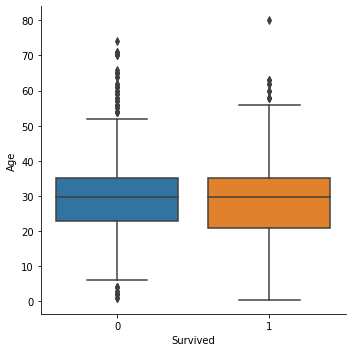

In [14]:
sns.catplot(x="Survived", y="Age", kind="box", data=train_data_mod)

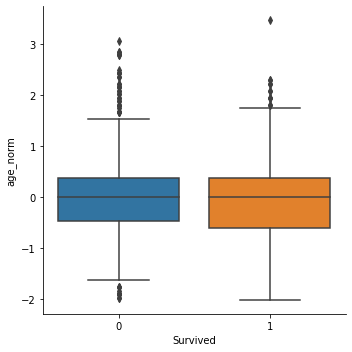

In [15]:
sns.catplot(x="Survived", y="age_norm", kind="box", data=train_data_mod)

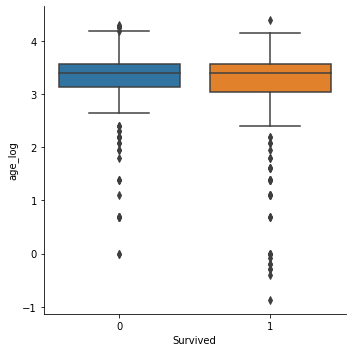

In [16]:
sns.catplot(x="Survived", y="age_log", kind="box", data=train_data_mod)

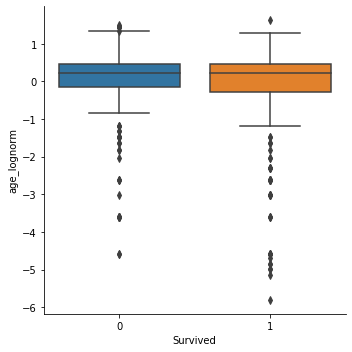

In [17]:
sns.catplot(x="Survived", y="age_lognorm", kind="box", data=train_data_mod)

Okay, so normalising the variables doesn't make a difference to the overall shape of the distribution, but the log transform does. Going forward, we'll use the "age_log" variable in place of age

In [18]:
train_data_mod.drop(["Age", "age_norm", "age_lognorm"], axis=1, inplace=True)

#### Fare

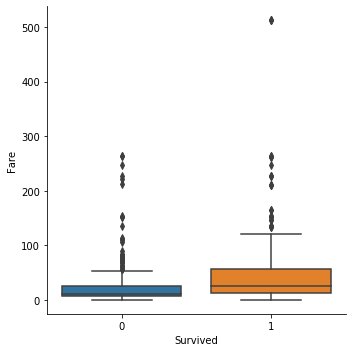

In [19]:
sns.catplot(x="Survived", y="Fare", kind="box", data=train_data_mod)

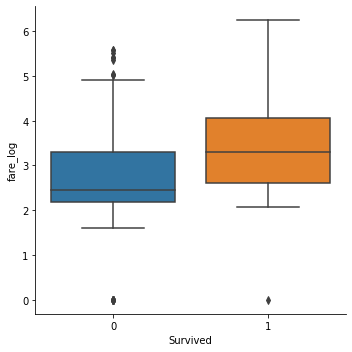

In [20]:
sns.catplot(x="Survived", y="fare_log", kind="box", data=train_data_mod)

Again, we'll continue with the "fare_log" variant

In [21]:
train_data_mod.drop(["Fare", "fare_norm", "fare_lognorm"], axis=1, inplace=True)

## Inital Model Testing

The purpose here is to generate a base model such that we get a benchmark statistic to compare later and (hopefully) more sophisticated models with. 

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, confusion_matrix

X = train_data_mod.drop(["Survived"], axis=1)
y = train_data_mod["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
inital_model = LogisticRegression()
inital_model.fit(X_train, y_train)
initial_preds = inital_model.predict(X_test)

initial_cm = confusion_matrix(y_test, initial_preds)

initial_score = inital_model.score(X_test, y_test)

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [23]:
initial_cm

array([[118,  21],
       [ 22,  62]])

In [24]:
initial_score

0.8071748878923767

So, following this we obtain an initial score of 0.81. Our confusion matrix is very much in need of improvement, however, with nearly a third of the classifications incorrect. Clearly this can be improved.

### Factor shortlisting

In [25]:
ivDF, woeDF = iv_woe(train_data_mod, 'Survived', factor_exclusions=[])

print(ivDF.sort_values(by=['IV'], ascending=False).to_string(index=False))

      Variable        IV
     is_female  1.341681
      fare_log  0.625860
        Pclass  0.500950
 cabin_missing  0.421963
         SibSp  0.180868
  embarked_cde  0.131556
         Parch  0.124605
       age_log  0.105002
   age_missing  0.037609


In [26]:
predictive_vars = list(ivDF[ivDF["IV"] > 0.1]["Variable"])
train_data_final = train_data_mod[predictive_vars + ["Survived"]]

### Multifactor Analysis

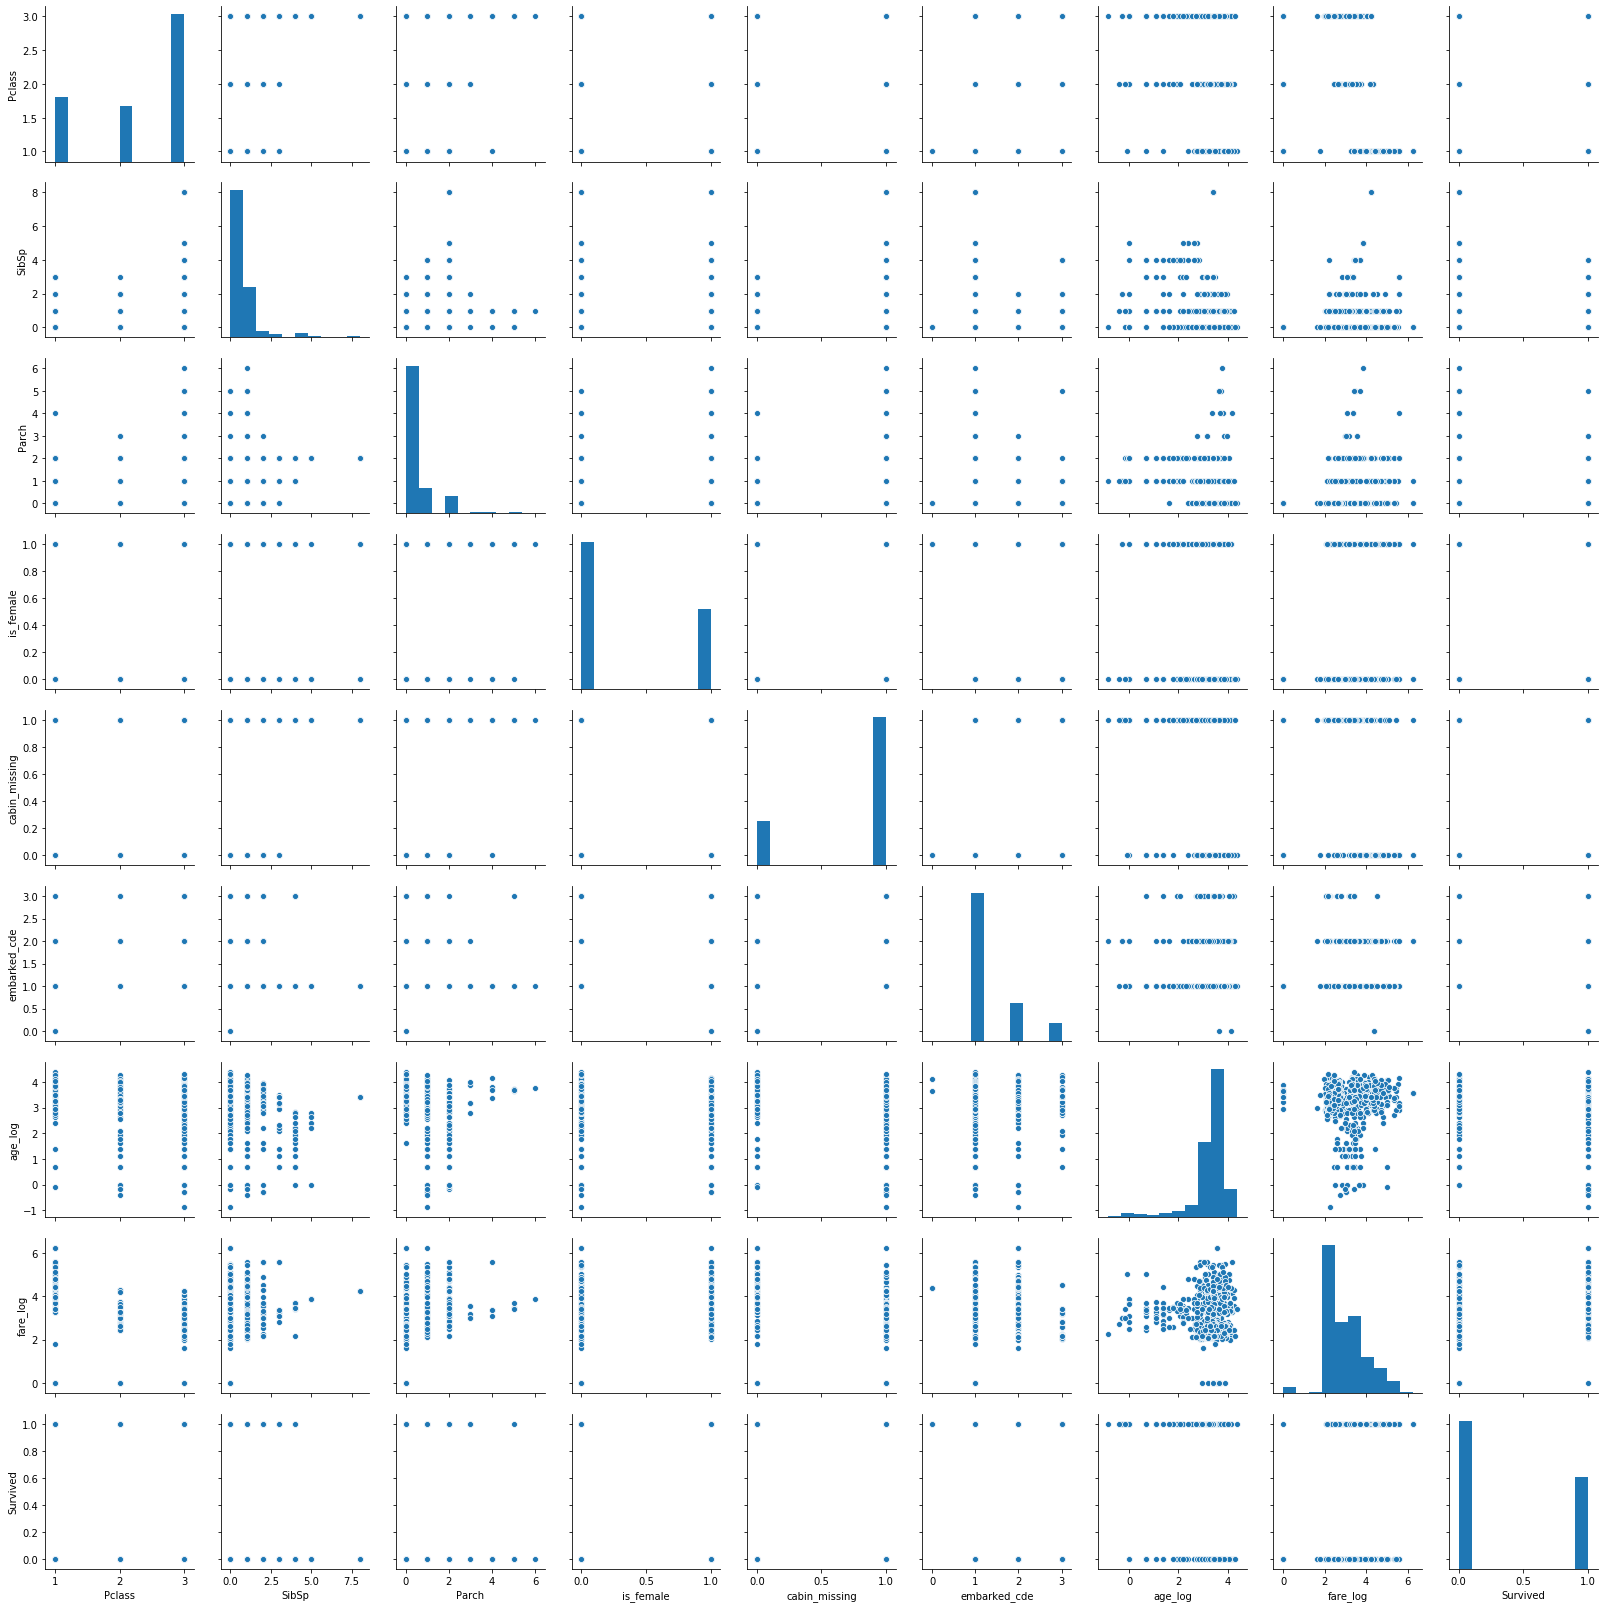

In [27]:
sns.pairplot(train_data_final)

We should check for collinearity between the two continuous numerical variables: age_log and fare_log

In [28]:
train_data_final["age_log"].corr(train_data_final["fare_log"])

-0.00017223464896595222

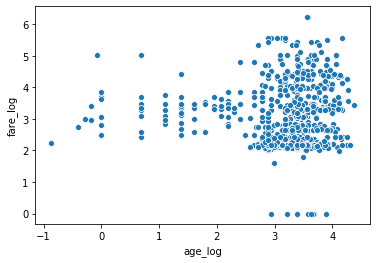

In [29]:
sns.scatterplot(x="age_log", y="fare_log", data=train_data_final)

No correlation is observed, which is what we want.

### Variable Combinations

In [30]:
from itertools import chain, combinations

def powerset(iterable):
    """
    powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)
    """
    xs = list(iterable)
    # note we return an iterator rather than a list
    return chain.from_iterable(combinations(xs,n) for n in range(len(xs)+1))

target_variable = 'Survived'
model_variables = [var for var in train_data_final.columns if var != target_variable]
model_combinations = list(enumerate([list(varset) for varset in powerset(model_variables) if list(varset) != []]))
model_combinations

[(0, ['Pclass']),
 (1, ['SibSp']),
 (2, ['Parch']),
 (3, ['is_female']),
 (4, ['cabin_missing']),
 (5, ['embarked_cde']),
 (6, ['age_log']),
 (7, ['fare_log']),
 (8, ['Pclass', 'SibSp']),
 (9, ['Pclass', 'Parch']),
 (10, ['Pclass', 'is_female']),
 (11, ['Pclass', 'cabin_missing']),
 (12, ['Pclass', 'embarked_cde']),
 (13, ['Pclass', 'age_log']),
 (14, ['Pclass', 'fare_log']),
 (15, ['SibSp', 'Parch']),
 (16, ['SibSp', 'is_female']),
 (17, ['SibSp', 'cabin_missing']),
 (18, ['SibSp', 'embarked_cde']),
 (19, ['SibSp', 'age_log']),
 (20, ['SibSp', 'fare_log']),
 (21, ['Parch', 'is_female']),
 (22, ['Parch', 'cabin_missing']),
 (23, ['Parch', 'embarked_cde']),
 (24, ['Parch', 'age_log']),
 (25, ['Parch', 'fare_log']),
 (26, ['is_female', 'cabin_missing']),
 (27, ['is_female', 'embarked_cde']),
 (28, ['is_female', 'age_log']),
 (29, ['is_female', 'fare_log']),
 (30, ['cabin_missing', 'embarked_cde']),
 (31, ['cabin_missing', 'age_log']),
 (32, ['cabin_missing', 'fare_log']),
 (33, ['embarke

#### Where I'm going with this:

So, we now have an enumerated list of all the variable combinations. What we can do now is construct various models, using various algorithms, and save the metrics to each model in a results data structure.

The algorithm's we're going to use are the following:
1. Logistic regression
2. Decision Trees
3. Random Forests
4. XGBoost
5. Some deep learning algorithm (don't know which one yet)

And the metrics we can use to compare are:
1. AIC/BIC
2. Correct Classification Rate

The classification rate metric is self-explanatory. AIC and BIC award accuracy, but also penalise increasing number of variables in a model. For stability and performance reasons, a smaller number of variables is preferable if a negligible reduction in accuracy is observed

In [31]:
def model_aic(actuals, predictions, num_vars):
    residuals = np.subtract(actuals, predictions)
    print(residuals)
    residual_sse = np.sum(residuals**2)
    return 2*num_vars - 2*np.log(residual_sse)

def equality(a,b):
    if a==b:
        return 1
    else:
        return 0

def model_cr(actuals, predictions):
    equality_count = np.sum([equality(a,p) for a,p in zip(actuals, predictions)])
    return equality_count/len(actuals)

In [32]:
test_actuals = np.array([0,1,0,1,0,1,0,1,0,1])
test_pred = np.array([0,1,0,0,1,0,1,0,0,1])
k = 100

# np.subtract(test_actuals, test_pred)
len(test_actuals)

10

In [33]:
model_aic(test_actuals, test_pred, k)

[ 0  0  0  1 -1  1 -1  1  0  0]


196.7811241751318

In [34]:
model_cr(test_actuals, test_pred)

0.5

## Model Testing

Here we go

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

def get_lr_performance(X_train, X_test, y_train, y_test, num_vars):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    aic = model_aic(y_test, preds, num_vars)
#     cr = model_cr(y_test, preds)
    cr = model.score(X_test, y_test)
    return aic, cr

def get_dt_performance(X_train, X_test, y_train, y_test, num_vars):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    aic = model_aic(y_test, preds, num_vars)
#     cr = model_cr(y_test, preds)
    cr = model.score(X_test, y_test)
    return aic, cr

def get_rf_performance(X_train, X_test, y_train, y_test, num_vars):
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    aic = model_aic(y_test, preds, num_vars)
#     cr = model_cr(y_test, preds)
    cr = model.score(X_test, y_test)
    return aic, cr

def get_xgb_performance(X_train, X_test, y_train, y_test, num_vars):
    model = GradientBoostingClassifier()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    aic = model_aic(y_test, preds, num_vars)
#     cr = model_cr(y_test, preds)
    cr = model.score(X_test, y_test)
    return aic, cr

def model_scoring(data, target, combinations):
    total_models = len(combinations)
    model_indices = [x for x in range(total_models)]
    
    aic_df = pd.DataFrame(columns=["LR", "DT", "RF", "XGB"], index=model_indices)
    cr_df = pd.DataFrame(columns=["LR", "DT", "RF", "XGB"], index=model_indices)
    
    for row in combinations:
        index, model = row
        num_vars = len(model)
        df_input = data[model]
        df_target = data[target]
        X_train, X_test, Y_train, Y_test = train_test_split(df_input, df_target, random_state=0)
        
        lr_aic, lr_cr = get_lr_performance(X_train, X_test, y_train, y_test, num_vars)
        dt_aic, dt_cr = get_dt_performance(X_train, X_test, y_train, y_test, num_vars)
        rf_aic, rf_cr = get_rf_performance(X_train, X_test, y_train, y_test, num_vars)
        xgb_aic, xgb_cr = get_xgb_performance(X_train, X_test, y_train, y_test, num_vars)
        
        aic_df.loc[index] = [lr_aic, dt_aic, rf_aic, xgb_aic]
        cr_df.loc[index] = [lr_cr, dt_cr, rf_cr, xgb_cr]
        
    return aic_df, cr_df
        
aic_df, cr_df = model_scoring(train_data_final, "Survived", model_combinations)

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    1
      ..
167    0
306    1
379    0
742    1
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167   -1
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167   -1
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    1
      ..
167    0
306    1
379    0
742    1
10     1
Name: Survived, Length: 223, dtype: int64
495   -1
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495   -1
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495   -1
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    1
      ..
167    0
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    1
      ..
167    0
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278   -1
31     1
255    1
      ..
167   -1
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278   -1
31     1
255    1
      ..
167    0
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     1
255    0
      ..
167    0
306    1
379    0
742    1
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    1
      ..
167    0
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    0
      ..
167   -1
306    1
379    0
742    1
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    1
      ..
167    0
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167   -1
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167   -1
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    1
      ..
167   -1
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278   -1
31     1
255    0
      ..
167   -1
306    1
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    0
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495   -1
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    0
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    1
      ..
167    0
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    1
      ..
167    0
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


495    0
648    0
278   -1
31     1
255    1
      ..
167    0
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    1
      ..
167   -1
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278   -1
31     1
255    1
      ..
167   -1
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     1
255    1
      ..
167   -1
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    0
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278   -1
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648   -1
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278   -1
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    1
      ..
167    0
306    0
379    0
742    1
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     1
255    0
      ..
167    0
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278   -1
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167   -1
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    0
      ..
167   -1
306    1
379    0
742    1
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    0
      ..
167   -1
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    0
      ..
167    0
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167   -1
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    1
      ..
167   -1
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167   -1
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    1
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    1
      ..
167    0
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278   -1
31     1
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278   -1
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278   -1
31     1
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     1
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278   -1
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278   -1
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495   -1
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278   -1
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167   -1
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167   -1
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278   -1
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278   -1
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379   -1
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    1
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    1
      ..
167    0
306    1
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278   -1
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    0
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    0
      ..
167    0
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     1
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278   -1
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     1
255    0
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    1
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167   -1
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    0
      ..
167   -1
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495   -1
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495   -1
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278   -1
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


495    0
648    0
278   -1
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278   -1
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495   -1
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495   -1
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495   -1
648    0
278    0
31     0
255    1
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278   -1
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379   -1
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379   -1
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64


/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    0
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495   -1
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


495    0
648    0
278    0
31     1
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    0
      ..
167   -1
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278   -1
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648   -1
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379   -1
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     1
255    0
      ..
167    0
306    0
379   -1
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278   -1
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379   -1
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495   -1
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495   -1
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495   -1
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495   -1
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495   -1
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495   -1
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278   -1
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495   -1
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495   -1
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python

495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64


/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    1
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    0
      ..
167   -1
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64


/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278   -1
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    0
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    1
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495   -1
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495   -1
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167   -1
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    1
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     1
255    0
      ..
167   -1
306    1
379    0
742    1
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495   -1
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495   -1
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495   -1
648 

/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mikie/Programming/Python/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     1
Name: Survived, Length: 223, dtype: int64
495    0
648    0
278    0
31     0
255    0
      ..
167    0
306    0
379    0
742    0
10     0
Name: Survived, Length: 223, dtype: int64


In [77]:
aic_df

,LR,DT,RF,XGB
0,-6.34877,-6.34877,-6.58092,-6.34877
1,-6.86163,-6.81344,-6.81344,-6.81344
2,-6.93182,-6.7889,-6.7889,-6.7889
3,-5.78364,-5.78364,-5.78364,-5.78364
4,-6.28627,-6.28627,-6.28627,-6.28627
...,...,...,...,...
250,6.05942,5.44667,5.77825,5.9139
251,6.34272,6.02203,6.57286,6.8893
252,6.43162,6.2997,6.8893,6.83296
253,6.52466,6.4776,6.2576,6.67288


In [78]:
cr_df

,LR,DT,RF,XGB
0,0.70852,0.70852,0.672646,0.70852
1,0.623318,0.632287,0.632287,0.632287
2,0.609865,0.636771,0.636771,0.636771
3,0.780269,0.780269,0.780269,0.780269
4,0.717489,0.717489,0.717489,0.717489
...,...,...,...,...
250,0.762332,0.67713,0.726457,0.744395
251,0.793722,0.757848,0.816143,0.843049
252,0.802691,0.789238,0.843049,0.838565
253,0.811659,0.807175,0.784753,0.825112


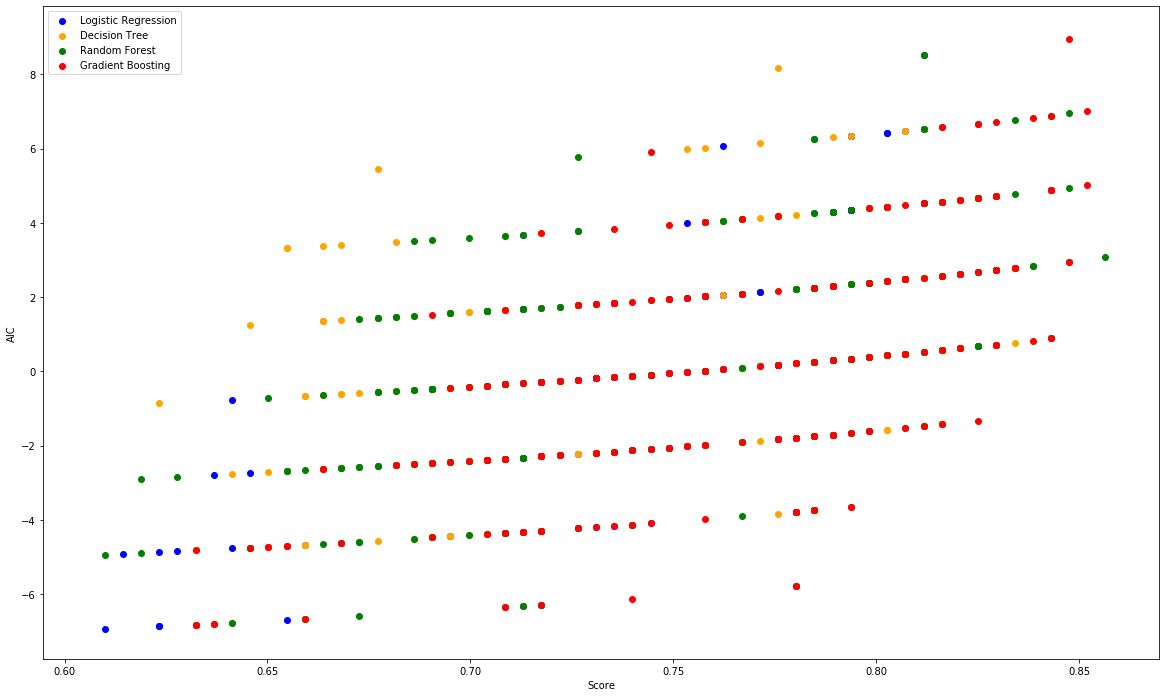

In [79]:
plt.figure(figsize=(20,12))
plt.scatter(cr_df["LR"], aic_df["LR"], label="Logistic Regression", color="blue")
plt.scatter(cr_df["DT"], aic_df["DT"], label="Decision Tree", color="orange")
plt.scatter(cr_df["RF"], aic_df["RF"], label="Random Forest", color="green")
plt.scatter(cr_df["XGB"], aic_df["XGB"], label="Gradient Boosting", color="red")

plt.xlabel("Score")
plt.ylabel("AIC")
plt.legend()

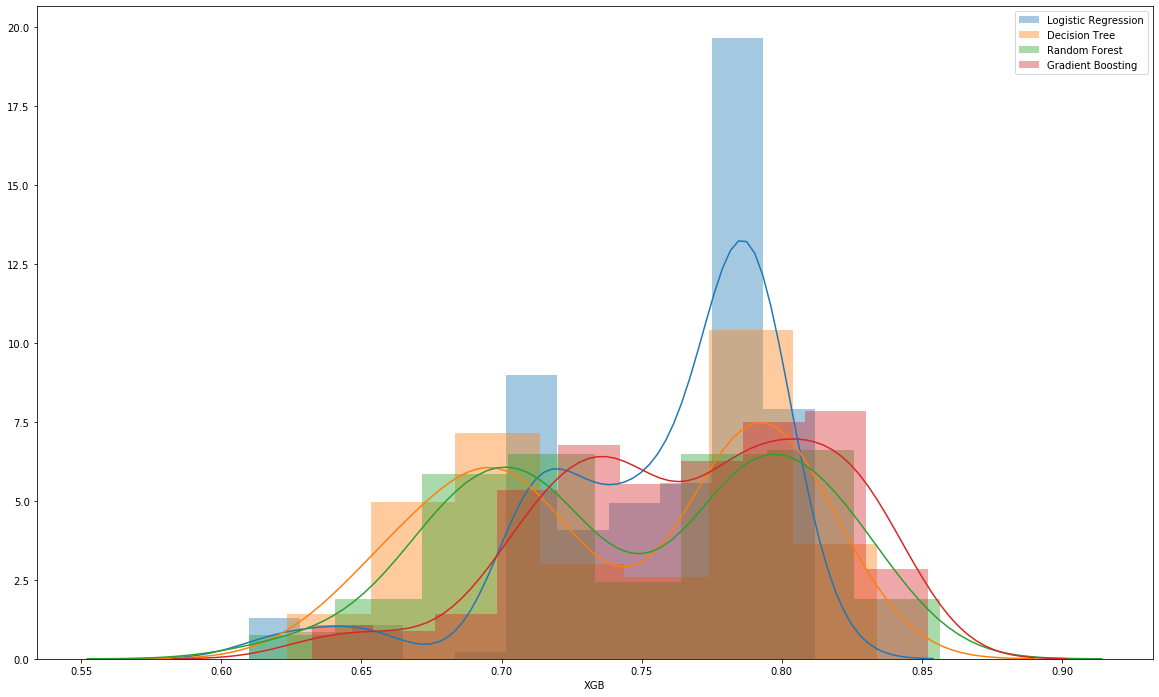

In [80]:
plt.figure(figsize=(20,12))
sns.distplot(cr_df["LR"], label="Logistic Regression")
sns.distplot(cr_df["DT"], label="Decision Tree")
sns.distplot(cr_df["RF"], label="Random Forest")
sns.distplot(cr_df["XGB"], label="Gradient Boosting")

plt.legend()

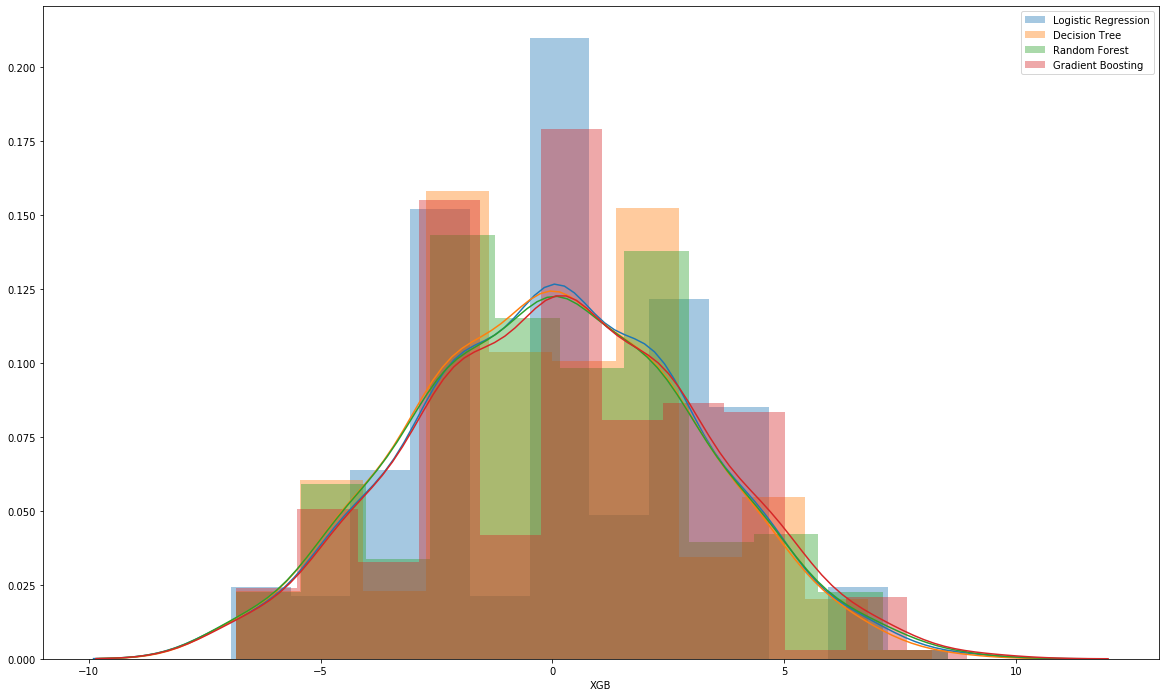

In [81]:
plt.figure(figsize=(20,12))
sns.distplot(aic_df["LR"], label="Logistic Regression")
sns.distplot(aic_df["DT"], label="Decision Tree")
sns.distplot(aic_df["RF"], label="Random Forest")
sns.distplot(aic_df["XGB"], label="Gradient Boosting")

plt.legend()

In [82]:
cr_df["Max CR"] = cr_df[["LR","DT","RF","XGB"]].max(axis=1)
cr_df

,LR,DT,RF,XGB,Max CR
0,0.70852,0.70852,0.672646,0.70852,0.708520
1,0.623318,0.632287,0.632287,0.632287,0.632287
2,0.609865,0.636771,0.636771,0.636771,0.636771
3,0.780269,0.780269,0.780269,0.780269,0.780269
4,0.717489,0.717489,0.717489,0.717489,0.717489
...,...,...,...,...,...
250,0.762332,0.67713,0.726457,0.744395,0.762332
251,0.793722,0.757848,0.816143,0.843049,0.843049
252,0.802691,0.789238,0.843049,0.838565,0.843049
253,0.811659,0.807175,0.784753,0.825112,0.825112


In [83]:
high_cr_models = cr_df[cr_df["Max CR"] > 0.85]
high_cr_models

,LR,DT,RF,XGB,Max CR
165,0.789238,0.834081,0.856502,0.829596,0.856502
231,0.793722,0.762332,0.816143,0.852018,0.852018
249,0.807175,0.753363,0.847534,0.852018,0.852018


In [87]:
high_cr_model_labels = list(high_cr_models.index)

In [88]:
aic_df["Min AIC"] = aic_df[["LR","DT","RF","XGB"]].min(axis=1)
aic_df.loc[high_cr_model_labels]

,LR,DT,RF,XGB,Min AIC
165,2.2997,2.77816,3.06853,2.72483,2.299705
231,4.34272,4.05942,4.57286,5.00698,4.059416
249,6.4776,5.98533,6.94728,7.00698,5.985334


So, here we see that model 165 has a good correctness ratio and a reasonable AIC. The random forest algorithm using this variable combination maximises the correctness ratio, whilst the logistic regression minimises the AIC. Model 165 is definitely the variable combination to progress with, but using which algorithm?

Well, the random forest optimises the CR but also has the highest AIC. But is the AIC high enough for this algorithm to choose another? I don't think so: we'll use the random forest going forward.

In [90]:
final_model_index, final_model_vars = model_combinations[165]
final_model_vars

['Pclass', 'SibSp', 'Parch', 'is_female', 'fare_log']

I'm not surprised to see the class, sex and fare variables make it into the final model. I am somewhat surprised to see the "SibSp" and "Parch" variables, but this is not a deterrant. Now we can make the final predictions!

## Final Predictions

Using the Random Forest Classifier

In [116]:
final_model = RandomForestClassifier()
final_model.fit(train_data_final[final_model_vars], train_data_final["Survived"])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [117]:
test_data_mod = test_data

# Codifying variables
test_data_mod["is_female"] = test_data_mod["Sex"].apply(is_female)

# Fare transforms
test_data_mod["fare_log"] = np.log(test_data_mod["Fare"] + 1) # Min fare = 0, which is undefined in log space. Log(x + 1) ~ log(x)
test_data_mod["fare_log"] = test_data_mod["fare_log"].fillna(0)

test_data_mod = test_data_mod[final_model_vars]
test_data_mod.describe()

,Pclass,SibSp,Parch,is_female,fare_log
count,418.000000,418.000000,418.000000,418.000000,418.000000
mean,2.265550,0.447368,0.392344,0.363636,3.008871
std,0.841838,0.896760,0.981429,0.481622,0.978026
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,2.185579
50%,3.000000,0.000000,0.000000,0.000000,2.737881
75%,3.000000,1.000000,0.000000,1.000000,3.480373
max,3.000000,8.000000,9.000000,1.000000,6.240917


In [118]:
final_predictions = final_model.predict(test_data_mod)

final_predictions_df = {"PassengerId": list(test_data["PassengerId"]), "Survived":final_predictions}
final_predictions_df = pd.DataFrame(final_predictions_df, columns=["PassengerId", "Survived"])
final_predictions_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [119]:
test_data["PassengerId"]

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [120]:
len(final_predictions)

418

In [122]:
final_predictions_df.to_csv("~/Programming/Python/datasci/code/projects/titanic/titanic_predictions_rf.csv", index=False)

This method obtained a score of 0.74641. This can be improved

## Final Predictions 2.0: Gradient Boosting

In [123]:
final_final_model = GradientBoostingClassifier()
final_final_model.fit(train_data_final[final_model_vars], train_data_final["Survived"])

final_final_predictions = final_final_model.predict(test_data_mod)

final_final_predictions_df = {"PassengerId": list(test_data["PassengerId"]), "Survived":final_final_predictions}
final_final_predictions_df = pd.DataFrame(final_final_predictions_df, columns=["PassengerId", "Survived"])
final_final_predictions_df

final_final_predictions_df.to_csv("~/Programming/Python/datasci/code/projects/titanic/titanic_predictions_xgb.csv", index=False)

This method obtained a score of 0.78947. This is a pretty big improvement on the RF score of 0.74, but goes against the intuition we developed using the tests above to select the optimal algorithm.

This touches on a point that constantly crops up in data science: *everything* needs to be tested, the bigger and more comprehensive the tests, the better.

Furthermore, our models here fell into a classic trap that catches a lot of data scientists out; we overfitted the model to the training dataset. The analysis above is limited to the training dataset as opposed to a combination of the training and the testing set. What we should have done here is filtered the training set (yes that does mean making the dataset smaller. More data != better data if it's not representative!) to better reflect the distributions seen in the test set. 

### Learnings:
1. More tests. For example cross-validation, bootstrapping, etc.
2. More representative training data. Filtering isn't a sin!